# Supplemental Figures

## Setup

### imports

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, pearsonr, linregress, zscore
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm

from dms_3d_features.plotting import (
    plot_pop_avg_from_row,
    publication_style_ax,
    plot_motif_boxplot_stripplot,
    plot_scatter_w_best_fit_line,
    format_small_plot,
)

## load data

In [3]:
DATA_PATH = "../../data"

In [4]:
df_construct = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_1.json")
df_construct_2 = pd.read_json(f"{DATA_PATH}/raw-jsons/constructs/pdb_library_2.json")
df_contruct_nomod = pd.read_json(
    f"{DATA_PATH}/raw-jsons/constructs/pdb_library_nomod.json"
)
df_motif = pd.read_json(
    f"{DATA_PATH}/raw-jsons/motifs/pdb_library_1_motifs_standard.json"
)
df = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")

# generate natural log of DMS
with np.errstate(divide="ignore"):
    df["ln_r_data"] = np.log(df["r_data"])
df["ln_r_data"].replace(-np.inf, -9.8, inplace=True)
# remove outliers
df = df.query("r_data_outlier == False").copy()

In [9]:
def generate_replicate_df(df_construct: pd.DataFrame, df_construct_2) -> pd.DataFrame:
    """
    Generates a replicate DataFrame by merging two input DataFrames based on the 'name' column.

    Args:
        df_construct (pandas.DataFrame): The first DataFrame containing the 'name' and 'data' columns.
        df_construct_2 (pandas.DataFrame): The second DataFrame containing the 'name' and 'data' columns.

    Returns:
        pandas.DataFrame: A new DataFrame with columns 'data_1' and 'data_2', where
            each row contains a pair of corresponding data values from the input DataFrames.

    Raises:
        None
    """
    df_2_sub = df_construct_2[["name", "data"]].copy()
    df_2_sub.rename(columns={"data": "data_2"}, inplace=True)
    df_merge = df_construct.merge(df_2_sub, on="name").copy()
    data = []
    for i, row in df_merge.iterrows():
        for d1, d2 in zip(row["data"], row["data_2"]):
            data.append({"data_1": d1, "data_2": d2})
    df_data = pd.DataFrame(data)
    return df_data

### extra functions

# Plotting

## Supplemental Figure 1: histogram of number of reads per construct

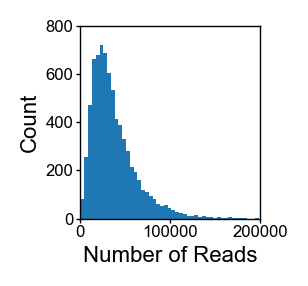

In [7]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
plt.hist(df_construct["num_aligned"], bins=100)
ax.set_xlabel("Number of Reads", labelpad=2)
ax.set_ylabel("Count", labelpad=2)
ax.set_xlim([0, 200000])
ax.set_xticks([0, 100000, 200000])
ax.set_yticks(range(0, 1000, 200))
format_small_plot(ax)

## Supplemental Figure 2: Correlation between DMS reactivity and nomod

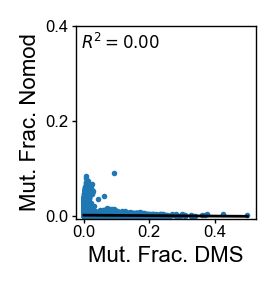

In [10]:
fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
df_data = generate_replicate_df(df_construct, df_contruct_nomod)
plot_scatter_w_best_fit_line(df_data["data_1"], df_data["data_2"], ax=ax)
ax.set_xlabel("Mut. Frac. DMS", labelpad=2)
ax.set_ylabel("Mut. Frac. Nomod", labelpad=2)
ax.set_xticks([0.00, 0.20, 0.40])
ax.set_yticks([0.00, 0.20, 0.40])
format_small_plot(ax)

## Supplemental Figure XXX: reactivity vs standard dev

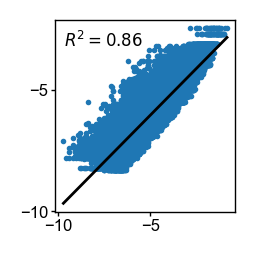

In [22]:
data = []
for i, group in df.groupby(["r_loc_pos", "m_sequence"]):
    std = group["r_data"].std()
    if std == 0:
        continue
    for _, row in group.iterrows():
        if row["r_data"] == 0:
            continue
        data.append([row["r_data"], std])
df_data = pd.DataFrame(data, columns=["r_data", "std"])
df_data["ln_r_data"] = np.log(df_data["r_data"])

fig, ax = plt.subplots(figsize=(1.50, 1.25), dpi=200)
plot_scatter_w_best_fit_line(np.log(df_data["r_data"]), np.log(df_data["std"]), ax=ax)
format_small_plot(ax)